In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from main import create_state_data, create_app

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
app = create_app()

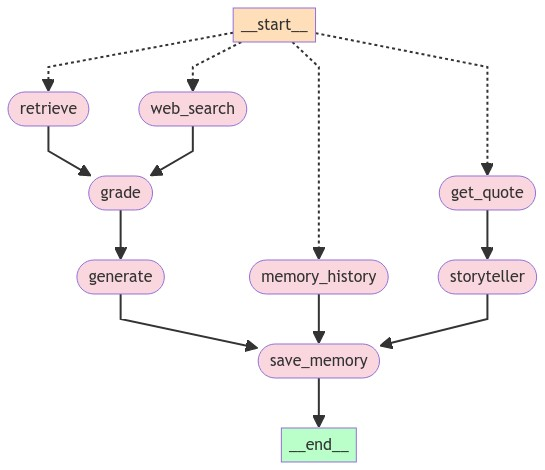

In [7]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
state = create_state_data()

In [6]:
state

{'runnable': {'query_router': ChatPromptTemplate(input_variables=['question'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='\n    You are an expert at routing a user question to a \n    vectorstore, web search, telling a story if the user wants or retrieve\n    information about the conversation history. \n    \n    The vectorstore contains documents related to artificial \n    intelligence and machine learning. It is a good source of \n    information for these topics.\n      Use the vectorstore to answer \n    questions related to these topics or the memory for retrieve information about our conversation history. Otherwise, use web search \n    to find the answer. Finally, if the user wants to hear a story, tell a story from a quote."\n    ')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], template='{question}'))])
  | RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions ob

#### Decision node

This node is responsible  of routing to 'vector_storage', 'web_search', 'storyteller' or 'memory'

In [7]:
vector_storage_question = "what are the disadvantages of artificial intelligence?"
out = state['runnable']['query_router'].invoke({'question': vector_storage_question})
out

RouterQuery(route='vector_storage')

In [8]:
question_web_search = "Tell me something about eurocup or 'copa america'"
out = state['runnable']['query_router'].invoke({'question': question_web_search})
out

RouterQuery(route='web_search')

In [9]:
quote_question = "Tell me a quote"
out = state['runnable']['query_router'].invoke({'question': quote_question})
out

RouterQuery(route='storyteller')

In [10]:
question_memory = "What is my name?"
out = state['runnable']['query_router'].invoke({'question': question_memory})
out

RouterQuery(route='memory')

#### Retriever node

This node is in charge of getting information from the vectorstorage, in our case it contains information about two artificial intelligence items 

In [11]:
vector_storage_question = "what are the disadvantages of artificial intelligence?"
state['runnable']['vector_storage_retriever'].invoke(vector_storage_question)

[Document(page_content='Technological unemployment\nMain articles: Workplace impact of artificial intelligence and Technological unemployment\nEconomists have frequently highlighted the risks of redundancies from AI, and speculated about unemployment if there is no adequate social policy for full employment.[209]\nIn the past, technology has tended to increase rather than reduce total employment, but economists acknowledge that "we\'re in uncharted territory" with AI.[210] A survey of economists showed disagreement about whether the increasing use of robots and AI will cause a substantial increase in long-term unemployment, but they generally agree that it could be a net benefit if productivity gains are redistributed.[211] Risk estimates vary; for example, in the 2010s, Michael Osborne and Carl Benedikt Frey estimated 47% of U.S. jobs are at "high risk" of potential automation, while an OECD report classified only 9% of U.S. jobs as "high risk".[o][213] The methodology of speculating 

#### Web_search node
This node is in charge of obtaining information through the tavilty API. 

In [12]:
question_web_search = "Tell me something about eurocup or 'copa america'"
response_web_search = state['runnable']['web_search'].invoke(question_web_search)
response_web_search

[Document(page_content='This Friday, June 14 marks the beginning of a memorable month for soccer fans in the United States and Latin America, as for four weeks they will be able to watch the best national teams in the world throughout the day: in the morning and afternoon, the Euro 2024, and at night, the Copa America 2024.With the permission of Asia and Africa, but it will be like a World Cup divided in two.', metadata={'title': 'Euro vs Copa America: What are the 5 main differences between these ...', 'source': 'https://www.metroworldnews.com/en/2024/06/14/euro-vs-copa-america-what-are-the-5-main-differences-between-these-soccer-tournaments/', 'score': 0.98956, 'images': None}),
 Document(page_content='The Copa America will come down to three or four teams. Having 16 teams affords more parity, as the unknowns become more common at the Euros since the number of teams increased to 24. Still, the quality of nations like Brazil, Argentina, Uruguay, or Colombia outmatches countries like P

#### Grade docs Node
This node generates a binary rating on whether the document is useful based on a question and the content of the document. 

In [13]:
doc_txt = response_web_search[0]
responde_grader = state['runnable']['grade_documents'].invoke({"document": doc_txt, "question": question_web_search})
responde_grader

GradeDocumnets(binary_core='yes')

#### Generate Node
This node is responsible for generating the text given a context (group of relevant documents).

In [14]:
# Run the chain
generation = state['runnable']['rag_chain'].invoke({"context": response_web_search, "question": question_web_search})
generation 

'The Euro 2024 and Copa America 2024 are two major soccer tournaments happening simultaneously, providing fans with a month of exciting matches. The Copa America features teams like Brazil, Argentina, Uruguay, and Colombia, known for their quality of play. The Euro Cup has increased to 24 teams, leading to more unknowns and parity among the participating nations.'

#### Get Quote Node
This node is responsible for querying the APININJA API https://api-ninjas.com/api/quotes.

In [15]:
import random
categories = ["age", "alone", "amazing", "anger", "architecture", "art", "attitude", "beauty", "best", "birthday", "business", "car", "change", "communication", "computers", "cool", "courage", "dad", "dating", "death", "design", "dreams", "education", "environmental", "equality", "experience", "failure", "faith", "family", "famous", "fear", "fitness", "food", "forgiveness", "freedom", "friendship", "funny", "future", "god", "good", "government", "graduation", "great", "happiness", "health", "history", "home", "hope", "humor", "imagination", "inspirational", "intelligence", "jealousy", "knowledge", "leadership", "learning", "legal", "life", "love", "marriage", "medical", "men", "mom", "money", "morning", "movies", "success"]

question = f"Give me a quote about {random.choice(categories)}"
print(question)

# Run the chain
generation_get_quote = state['runnable']['get_quote'].invoke(question)
generation_get_quote 

Give me a quote about forgiveness


[{'name': 'Quote',
  'args': {'category': 'forgiveness'},
  'id': 'call_6xMUUjHg9MwsdvqIeBT2Qtfv',
  'output': '[{"quote": "I find forgiveness to be really healthy.", "author": "Ben Affleck", "category": "forgiveness"}]'}]

#### storyteller Node 
This node is responsible for generating a history based on the query returned from APININJA API https://api-ninjas.com/api/quotes.

In [16]:
quote_2_story = eval(generation_get_quote[0]['output'])[0]
quote_2_story

{'quote': 'I find forgiveness to be really healthy.',
 'author': 'Ben Affleck',
 'category': 'forgiveness'}

In [17]:
# Run the chain
generate_story = state['runnable']['storyteller'].invoke(quote_2_story)
generate_story

StoryQuote(story="In the heart of a bustling city, there lived a man named Oliver. Oliver was known for his kind heart and gentle spirit. However, he carried a heavy burden from his past - a grudge he held against his childhood friend, Peter. The two had drifted apart after a misunderstanding, and Oliver's heart was consumed by bitterness and resentment. One day, as Oliver sat alone in a park, deep in thought, he remembered a quote he once heard: 'I find forgiveness to be really healthy.' These words, spoken by a wise sage, echoed in his mind. Oliver realized that he needed to let go of the anger that weighed him down. With a newfound determination, he set out to find Peter and make amends. As he stood face to face with his old friend, the words of forgiveness flowed from his lips, washing away years of hurt and pain. In that moment, Oliver felt a weight lifted off his shoulders, and a sense of peace washed over him. Forgiveness had indeed been the key to his healing.", quote='I find f

#### Memory history Node
This node is responsible for querying the session for relevant information in case the llm needs context from the history.

In [18]:
# First we need to create a storage and session
from storyteller_rag.utils import get_by_session_id

session = 'user_1'
storage = {}
storage = get_by_session_id(storage, session)
storage

InMemoryChatMessageHistory(messages=[])

In [19]:
# Now add some information to the storage
storage.add_ai_message('Im yout helper assistant, how can I help you?')
storage.add_user_message('Hi my name is Clarc, can you tell me a quote?')

In [20]:
storage

InMemoryChatMessageHistory(messages=[AIMessage(content='Im yout helper assistant, how can I help you?'), HumanMessage(content='Hi my name is Clarc, can you tell me a quote?')])

In [21]:
# Ask for the context of previous messages
question = "what is my name?"
input = {
    "input": question,
    "history": storage.messages,
        }

generate_memory = state['runnable']['memory_chain'].invoke(input)
generate_memory

AIMessage(content='Your name is Clarc.', response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 63, 'total_tokens': 69}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-54167e0c-829b-41fc-87b4-c176d224b13a-0', usage_metadata={'input_tokens': 63, 'output_tokens': 6, 'total_tokens': 69})

#### Testing the flows

##### 1) **storyflow**: this flow is Get Quote and queries the APININJA API to generate a random quote and subsequently creates a fun story based on this quote.

In [22]:
# update key in the state dict
state['question'] = "Can you tell me a quote?"
response_story_flow = app.invoke(state)

----ROUTE QUESTION----
----saving memory----
----ROUTE QUESTION----
----ROUTE QUESTION: Storyteller
------- GETTOING QUOTE -------
------- CREATING THE STORY -------


In [23]:
response_story_flow['generation']

AIMessage(content='{"story": "In the bustling city of New York, amidst the chaos of the 1930s, a young man named Frederick Reines embarked on a journey that would shape the course of his life. With a burning passion for knowledge and a thirst for understanding the mysteries of the universe, Frederick dedicated himself to the pursuit of education. He toiled tirelessly, immersing himself in the world of engineering at the prestigious Steven Institute of Technology. In 1939, amidst the echoes of history, Frederick proudly received his undergraduate degree in engineering, a symbol of his dedication and perseverance. But Frederick\'s thirst for knowledge knew no bounds. Fuelled by a relentless curiosity, he delved deeper into the realms of mathematical physics, seeking to unravel the secrets of the cosmos. In 1941, with a heart full of ambition and a mind brimming with possibilities, Frederick achieved a Master of Science degree in mathematical physics, a testament to his unwavering commitm

##### 2) **Web search flow**: Performs a search using the Tavily API

In [24]:
# update key in the state dict
state['question'] = "spain beat albania in their eurocup match ?"
response_web_search_flow = app.invoke(state)

----ROUTE QUESTION----
----saving memory----
----ROUTE QUESTION----
----ROUTE QUESTION: Web search
------- WEB SEARCH -------
------- GRADING DOCUMENT -------
--------- RELEVANT DOCUMENT ---------
--------- RELEVANT DOCUMENT ---------
--------- RELEVANT DOCUMENT ---------
---GENERATE---


In [25]:
response_web_search_flow['generation']

'Yes, Spain beat Albania 1-0 in their Euro 2024 match, with Ferran Torres scoring the winning goal. This victory ensured Spain maintained their 100% record in the tournament and eliminated Albania from the competition.'

##### 3) **Memory History**: Responds to queries about the conversation history.

In [26]:
# update key in the state dict
state['question'] = "can you give me a summary of what we have discussed? "
response_memory_flow = app.invoke(state)

----ROUTE QUESTION----
----saving memory----
----ROUTE QUESTION----
----ROUTE QUESTION: Memory
---GET MEMORY---


In [27]:
response_memory_flow['generation']

'We have discussed a quote by Frederick Reines about his educational achievements, as well as the result of the Euro 2024 match between Spain and Albania, where Spain emerged victorious with a 1-0 win.'

In [28]:
# print historical data 
state['memory'].messages

[HumanMessage(content='Can you tell me a quote?'),
 AIMessage(content='{"story": "In the bustling city of New York, amidst the chaos of the 1930s, a young man named Frederick Reines embarked on a journey that would shape the course of his life. With a burning passion for knowledge and a thirst for understanding the mysteries of the universe, Frederick dedicated himself to the pursuit of education. He toiled tirelessly, immersing himself in the world of engineering at the prestigious Steven Institute of Technology. In 1939, amidst the echoes of history, Frederick proudly received his undergraduate degree in engineering, a symbol of his dedication and perseverance. But Frederick\'s thirst for knowledge knew no bounds. Fuelled by a relentless curiosity, he delved deeper into the realms of mathematical physics, seeking to unravel the secrets of the cosmos. In 1941, with a heart full of ambition and a mind brimming with possibilities, Frederick achieved a Master of Science degree in mathema

##### 5) **Retrieve**: Retrieves data from vector storage.

In [29]:
# update key in the state dict
state['question'] = ("what are the disadvantages of artificial intelligence?")
response_vectorstore_flow = app.invoke(state)

----ROUTE QUESTION----
----saving memory----
----ROUTE QUESTION----
----ROUTE QUESTION: Vectorstore
------- RETRIEVING DOCUMENTS -------
------- GRADING DOCUMENT -------
--------- NOT RELEVANT DOCUMENT ---------
--------- NOT RELEVANT DOCUMENT ---------
--------- NOT RELEVANT DOCUMENT ---------
--------- NOT RELEVANT DOCUMENT ---------
---GENERATE---


In [30]:
response_vectorstore_flow['generation']

'Some disadvantages of artificial intelligence include potential job displacement, privacy concerns related to data collection, and the risk of bias in decision-making algorithms.'